<a href="https://colab.research.google.com/github/Mattlee10/zone2/blob/main/AWP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: export.xml을 CSV로 변환

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

# Google Drive에서 파일 경로 설정 (업로드한 위치에 맞게 수정)
file_path = "/content/drive/My Drive/export_L.xml"

# XML 파일 로드
tree = ET.parse(file_path)
root = tree.getroot()

print("✅ XML 파일이 성공적으로 로드되었습니다!")

✅ XML 파일이 성공적으로 로드되었습니다!


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

# Google Drive에서 XML 파일 경로 지정 (파일 경로를 실제 파일 위치에 맞게 수정)
file_path = "/content/drive/My Drive/export_L.xml"

# XML 파일 파싱
tree = ET.parse(file_path)
root = tree.getroot()

# 데이터를 저장할 리스트 생성
data = []

# 필요한 데이터 필터링
# 기존 HRV, 심박수, 칼로리 소모량(활동 에너지 소모) 외에,
# 유산소 능력 향상(VO2 Max), 지방 연소율, 운동 강도(예: Apple 운동 시간) 등 추가
target_types = {
    "HKQuantityTypeIdentifierHeartRateVariabilitySDNN": "HRV",
    "HKQuantityTypeIdentifierHeartRate": "Heart Rate",
    "HKQuantityTypeIdentifierActiveEnergyBurned": "Active Energy Burned",  # 칼로리 소모량
    "HKQuantityTypeIdentifierVO2Max": "VO2 Max",                    # 유산소 능력 향상
    "HKQuantityTypeIdentifierFatBurnRate": "Fat Burn Rate",          # 지방 연소율 (XML에 해당 데이터가 있다면)
    "HKQuantityTypeIdentifierAppleExerciseTime": "Exercise Time"     # 운동 강도 (특히 유산소)
}

for record in root.findall("Record"):
    record_type = record.get("type")
    if record_type in target_types:
        try:
            value = float(record.get("value"))
        except (TypeError, ValueError):
            continue  # value 변환이 불가능한 경우 스킵
        data.append({
            "type": target_types[record_type],
            "value": value,
            "unit": record.get("unit"),
            "timestamp": record.get("startDate")
        })

# DataFrame 생성
df = pd.DataFrame(data)

# Timestamp 컬럼을 datetime 형식으로 변환 및 정렬
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

# CSV 파일로 저장
csv_filename = "/content/drive/My Drive/health_data.csv"
df.to_csv(csv_filename, index=False)

print(f"✅ CSV 파일이 생성되었습니다: {csv_filename}")

# CSV 데이터 미리보기
df.head()

✅ CSV 파일이 생성되었습니다: /content/drive/My Drive/health_data.csv


,type,value,unit,timestamp
42208,Active Energy Burned,0.019,kcal,2024-06-12 08:27:16+09:00
42209,Active Energy Burned,0.107,kcal,2024-06-12 11:48:46+09:00
42210,Active Energy Burned,0.050,kcal,2024-06-12 12:04:46+09:00
42211,Active Energy Burned,9.647,kcal,2024-06-12 13:30:14+09:00
42212,Active Energy Burned,5.161,kcal,2024-06-12 13:50:24+09:00


In [ ]:
# CSV 파일 다시 로드
csv_filename = "/content/drive/My Drive/health_data.csv"
df = pd.read_csv(csv_filename)

# Timestamp 컬럼을 datetime 형식으로 변환 및 정렬
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

# 데이터 확인
print(f"✅ 총 데이터 개수: {len(df)}개")
df.head()

✅ 총 데이터 개수: 78383개


,type,value,unit,timestamp
0,Active Energy Burned,0.019,kcal,2024-06-12 08:27:16+09:00
1,Active Energy Burned,0.107,kcal,2024-06-12 11:48:46+09:00
2,Active Energy Burned,0.050,kcal,2024-06-12 12:04:46+09:00
3,Active Energy Burned,9.647,kcal,2024-06-12 13:30:14+09:00
4,Active Energy Burned,5.161,kcal,2024-06-12 13:50:24+09:00


# Stpe 2: 데이터 분석

데이터 분석(전처리)

In [ ]:
import pandas as pd
import numpy as np

# Google Drive에서 CSV 파일 로드
csv_filename = "/content/drive/My Drive/health_data.csv"
df = pd.read_csv(csv_filename)

# Timestamp를 datetime 형식으로 변환
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 이상치 제거 (심박수 기준: 30~220bpm, HRV: 10~200ms)
df = df[
    ((df["type"] == "Heart Rate") & (df["value"].between(30, 220))) |
    ((df["type"] == "HRV") & (df["value"].between(10, 200))) |
    ((df["type"] == "Active Energy") & (df["value"] > 0))
]

# 단위 변환 (HRV는 ms, 심박수는 bpm)
df.loc[df["type"] == "HRV", "value"] = df["value"].astype(float)  # HRV 값 보정

# 데이터 저장
cleaned_csv = "/content/drive/My Drive/cleaned_health_data.csv"
df.to_csv(cleaned_csv, index=False)
print(f"✅ 데이터 전처리 완료! 파일 저장: {cleaned_csv}")

# 데이터 확인
df.head()

✅ 데이터 전처리 완료! 파일 저장: /content/drive/My Drive/cleaned_health_data.csv


,type,value,unit,timestamp
3026,Heart Rate,80.0,count/min,2024-10-10 13:09:52+09:00
3028,Heart Rate,82.0,count/min,2024-10-10 13:11:37+09:00
3034,Heart Rate,88.0,count/min,2024-10-10 13:17:00+09:00
3043,Heart Rate,69.0,count/min,2024-10-10 13:22:03+09:00
3049,Heart Rate,83.0,count/min,2024-10-10 13:27:24+09:00


# Step 3: 데이터 시각화 및 해석

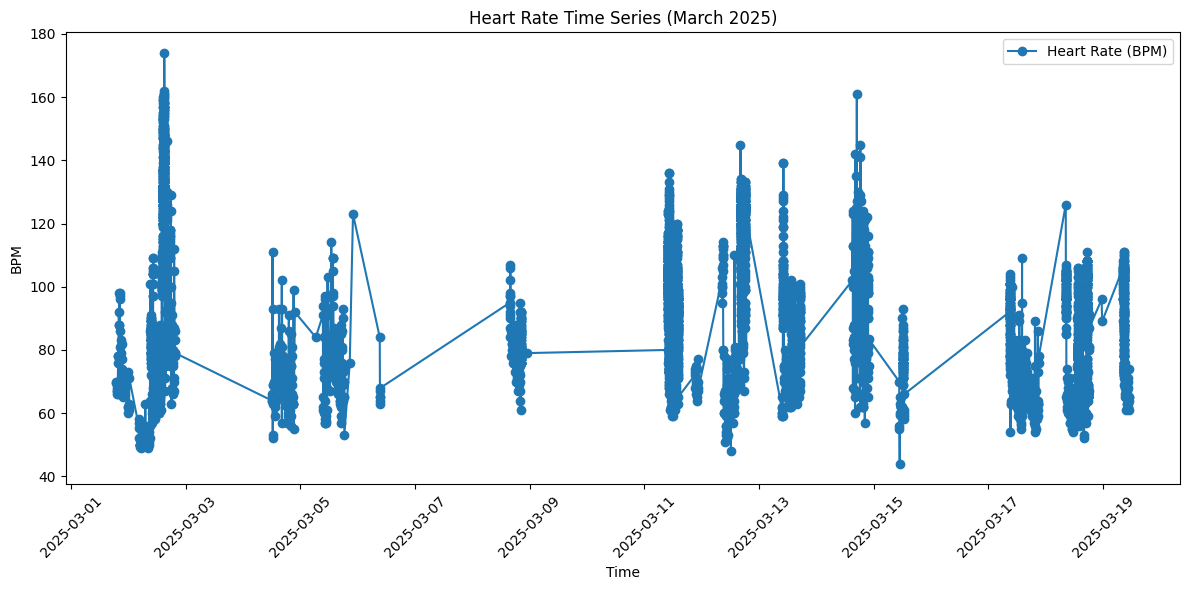

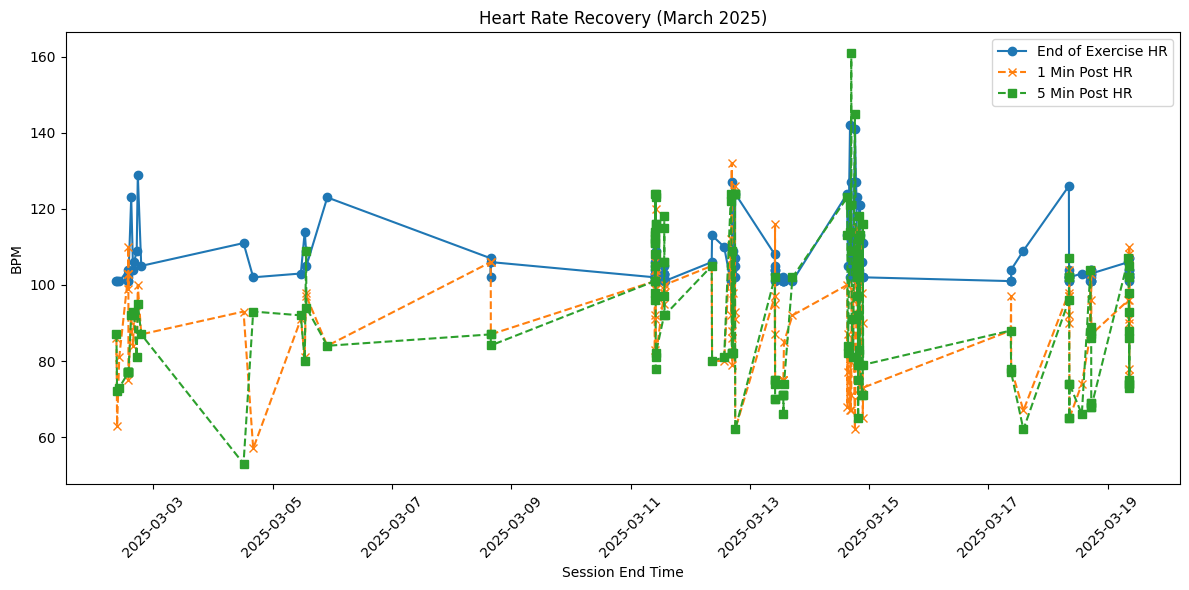

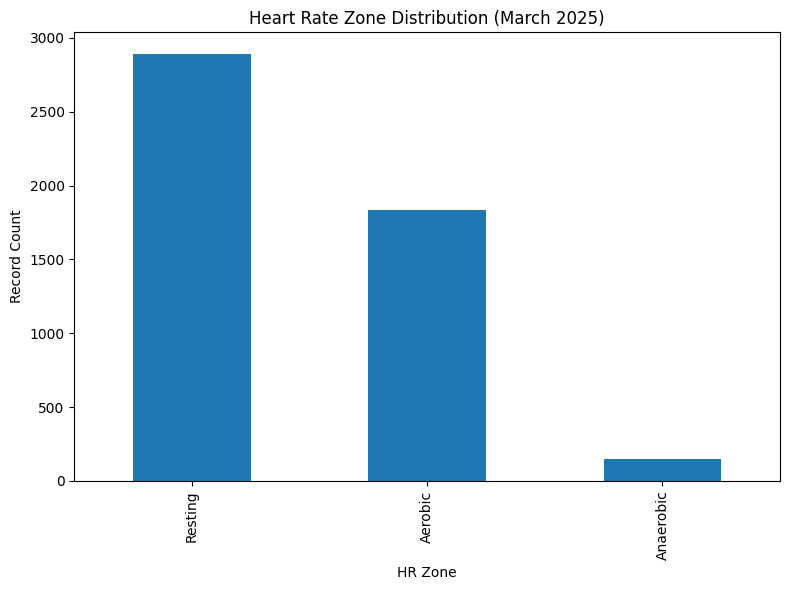

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 읽기 (이전 코드로 생성한 CSV 파일)
csv_filename = "/content/drive/My Drive/health_data.csv"
df = pd.read_csv(csv_filename)

# timestamp 컬럼을 datetime 형식으로 변환
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 25년도 3월 데이터만 필터링 (2025-03-01 ~ 2025-03-31)
start_date = "2025-03-01"
end_date = "2025-03-31"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
df_march = df.loc[mask]

# 심박수 데이터만 선택
hr_df = df_march[df_march["type"] == "Heart Rate"].copy()
hr_df = hr_df.sort_values(by="timestamp")

### 1. 운동 강도별 심박수 그래프 (시간에 따른 BPM 변화)
plt.figure(figsize=(12, 6))
plt.plot(hr_df["timestamp"], hr_df["value"], marker="o", linestyle="-", label="Heart Rate (BPM)")
plt.xlabel("Time")
plt.ylabel("BPM")
plt.title("Heart Rate Time Series (March 2025)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. 운동 후 1분 & 5분 회복 속도 시각화
# 임계값을 초과하면 운동 중으로 가정 (필요에 따라 조정)
exercise_threshold = 100
hr_df["in_exercise"] = hr_df["value"] > exercise_threshold

# 연속된 운동 구간을 구분하기 위해 변화점 기준 그룹화
hr_df["session_change"] = hr_df["in_exercise"].ne(hr_df["in_exercise"].shift()).cumsum()

# 운동 중 기록만 그룹핑하여 운동 세션별로 나눔
exercise_sessions = hr_df[hr_df["in_exercise"]].groupby("session_change")

recovery_data = []
for session_id, group in exercise_sessions:
    # 각 세션의 마지막 기록을 운동 종료 시점으로 가정
    session_end_time = group["timestamp"].iloc[-1]
    end_hr = group["value"].iloc[-1]

    # 운동 종료 1분, 5분 후 시각 계산
    one_min_after = session_end_time + pd.Timedelta(minutes=1)
    five_min_after = session_end_time + pd.Timedelta(minutes=5)

    # 1분 후, 5분 후 심박수: 해당 시각보다 늦은 첫 기록을 사용
    hr_after_1 = hr_df[hr_df["timestamp"] >= one_min_after]
    hr_1min = hr_after_1.iloc[0]["value"] if not hr_after_1.empty else np.nan

    hr_after_5 = hr_df[hr_df["timestamp"] >= five_min_after]
    hr_5min = hr_after_5.iloc[0]["value"] if not hr_after_5.empty else np.nan

    recovery_data.append({
        "session_end_time": session_end_time,
        "end_hr": end_hr,
        "hr_1min": hr_1min,
        "hr_5min": hr_5min,
        "recovery_1min": end_hr - hr_1min if not np.isnan(hr_1min) else np.nan,
        "recovery_5min": end_hr - hr_5min if not np.isnan(hr_5min) else np.nan,
    })

recovery_df = pd.DataFrame(recovery_data)

# 회복 속도 시각화: 운동 종료 시점, 1분 후, 5분 후 심박수를 선 그래프로 비교
plt.figure(figsize=(12, 6))
plt.plot(recovery_df["session_end_time"], recovery_df["end_hr"], marker="o", linestyle="-", label="End of Exercise HR")
plt.plot(recovery_df["session_end_time"], recovery_df["hr_1min"], marker="x", linestyle="--", label="1 Min Post HR")
plt.plot(recovery_df["session_end_time"], recovery_df["hr_5min"], marker="s", linestyle="--", label="5 Min Post HR")
plt.xlabel("Session End Time")
plt.ylabel("BPM")
plt.title("Heart Rate Recovery (March 2025)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. HR Zone (유산소 vs 무산소) 시각화
# 예시: 심박수 값에 따른 구간 분류
def hr_zone(bpm):
    if bpm < 100:
        return "Resting"
    elif 100 <= bpm < 140:
        return "Aerobic"
    else:
        return "Anaerobic"

hr_df["HR_zone"] = hr_df["value"].apply(hr_zone)
zone_counts = hr_df["HR_zone"].value_counts()

plt.figure(figsize=(8, 6))
zone_counts.plot(kind="bar")
plt.xlabel("HR Zone")
plt.ylabel("Record Count")
plt.title("Heart Rate Zone Distribution (March 2025)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def load_caresens_cgm(path):
    """
    CareSens Air CGM CSV 파일에서 아침 공복 혈당 데이터 추출
    - 시간: 07:00~08:00
    - 출력: 날짜별 평균 혈당
    """
    df = pd.read_csv(path)

    # 필요한 컬럼명으로 변경
    df['timestamp'] = pd.to_datetime(df['Date and Time'])
    df['glucose'] = pd.to_numeric(df['Glucose Value'], errors='coerce')

    df.dropna(subset=['glucose'], inplace=True)

    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 아침 7시 ~ 8시 사이의 측정값만 필터링
    fasting_df = df[(df['hour'] >= 6) & (df['hour'] < 9)]

    # 날짜별 공복 혈당 평균 계산
    result = fasting_df.groupby('date')['glucose'].mean().reset_index()
    result.columns = ['date', 'fasting_glucose']

    return result

In [ ]:
def get_fasting_glucose_by_date(path, target_date, hour_start=6, hour_end=9):
    """
    특정 날짜의 아침 공복 혈당 측정값을 개별적으로 출력
    """
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['Date and Time'])
    df['glucose'] = pd.to_numeric(df['Glucose Value'], errors='coerce')
    df.dropna(subset=['glucose'], inplace=True)
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 특정 날짜 + 시간대 필터링
    filtered = df[(df['date'] == target_date) &
                  (df['hour'] >= hour_start) &
                  (df['hour'] < hour_end)]

    return filtered[['timestamp', 'glucose']]

In [ ]:
# 예: 2025년 5월 9일
get_fasting_glucose_by_date('/content/drive/MyDrive/CareSensAir_Export_L.csv', pd.to_datetime("2025-05-09").date())

,timestamp,glucose
118,2025-05-09 06:00:29,107
119,2025-05-09 06:05:29,107
120,2025-05-09 06:10:29,107
121,2025-05-09 06:15:29,106
122,2025-05-09 06:20:29,106
123,2025-05-09 06:25:29,106
124,2025-05-09 06:30:29,106
125,2025-05-09 06:35:29,108
126,2025-05-09 06:40:29,109
127,2025-05-09 06:45:29,110


from matplotlib import pyplot as plt
_df_0['glucose'].plot(kind='hist', bins=20, title='glucose')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['glucose']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('glucose')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['glucose']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('glucose')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['glucose'].plot(kind='line', figsize=(8, 4), title='glucose')
plt.gca().spines[['top', 'right']].set_visible(False)